# Preparing a computer vision training set for classifying advertisements 

This notebook covers the steps involved in preparing a labeled dataset of images derived from the Newspaper Navigator dataset. Specifically this training set is primarily intended for use in a Programming Historian lesson on computer vision. 

## Aims 
This notebook cover the steps to creating a dataset based on the news-navigator dataset. This includes:
- creating a subsample of the news navigator training set
- setting up the annotation process
- processing the annotations 
- uploading the dataset to Zenodo

It doesn't cover training a model based on this data. This process is covered in a the programming historian lesson for which this dataset was created. 

## Requirements 
The easiest way to make sure you have the Python requirements available for this notebook is to install the package via PyPi into a new environment. Instructions can be found on the [README page](https://github.com/davanstrien/nnAnnotator/) for this repository.

### Importing required libraries

In [1]:
from nnAnnotator import sample

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json 
import requests
from pathlib import Path

Set plot style

In [3]:
plt.style.use('seaborn')

## Working with newspaper navigator dataset
The newspaper navigator dataset is available via a few different formats. nnAnnotator uses the JSON files, let's see how to access these. The JSON file is availabl via a URL that looks like this

In [4]:
'https://news-navigator.labs.loc.gov/prepackaged/1930_ads.json'

'https://news-navigator.labs.loc.gov/prepackaged/1930_ads.json'

All of these URLS follow the same patern:
https://news-navigator.labs.loc.gov/prepackaged/{YEAR}_{KIND}.json As a result it is very simple to grab the correct url for a year and kind of image in the dataset. This is what ```get_json_url``` does: 

In [5]:
sample.get_json_url(1940,'ads')

'https://news-navigator.labs.loc.gov/prepackaged/1940_ads.json'

Let's now take a look at an example for the maps data:

In [6]:
url = sample.get_json_url(1900,'maps')
with requests.get(url) as r:
    data = json.loads(r.content)

Take a look at the first record:

In [7]:
data[0]

{'filepath': 'dlc_alf_ver01/data/sn83045462/00280655351/1900092901/0515/006_2_91.jpg',
 'pub_date': '1900-09-29',
 'page_seq_num': 515,
 'edition_seq_num': 1,
 'batch': 'dlc_alf_ver01',
 'lccn': 'sn83045462',
 'box': [0.7022514105902777,
  0.022746477387920072,
  0.970748046875,
  0.23085515669300366],
 'score': 0.917590856552124,
 'ocr': ['The',
  'Positions',
  'of',
  'the',
  'Principal',
  'Stars',
  'wbtrh',
  'ore',
  'above',
  'the',
  'Horizon',
  'October',
  '1?15?31,',
  'at',
  '9',
  '8?7',
  'p.m.'],
 'place_of_publication': 'Washington, D.C.',
 'geographic_coverage': ['District of Columbia--Washington'],
 'name': 'Evening star. [volume]',
 'publisher': 'W.D. Wallach & Hope',
 'url': 'https://news-navigator.labs.loc.gov/data/dlc_alf_ver01/data/sn83045462/00280655351/1900092901/0515/006_2_91.jpg',
 'page_url': 'https://chroniclingamerica.loc.gov/data/batches/dlc_alf_ver01/data/sn83045462/00280655351/1900092901/0515.jp2'}

You can see there are a bunch of things we might be interested in using either for processing the data or for analysis. 

In [8]:
data[0].keys()

dict_keys(['filepath', 'pub_date', 'page_seq_num', 'edition_seq_num', 'batch', 'lccn', 'box', 'score', 'ocr', 'place_of_publication', 'geographic_coverage', 'name', 'publisher', 'url', 'page_url'])

Another notebook will cover the analysis part in more detail, so let's get back to the problem of constructing a dataset. 

# Sampling
Since the aim is to create a dataset for training a machine to predict the correct labels for the images we are likely to want a sample of the full dataset rather than the whole thing. Before we decide what sort of sample size might make sense. 

## View the amount of images for a year
Since each record is one image we can easily get the number of images by counting the lenght of a json file for a year and kind:

In [9]:
url = sample.get_json_url(1900,'maps')
r = requests.get(url)
data = json.loads(r.content)
print(f'{url} has: {len(data):,} image records')

https://news-navigator.labs.loc.gov/prepackaged/1900_maps.json has: 1,707 image records


## Out of memory data 
This works fine for the maps data but the size of some of the datasets, including those for ads, is too big to load into memory on some machine. Since we want to be able to do our create our sampling on standard device we can use  ```get_year_sizes``` to get the number of records for a type of image and a year. This function avoids loading the full data into memory so will work even if you only have a few GBs of RAM. The [Documentation]() !todo add link has more information on how this works. Let's grab the number of entries for maps:

In [10]:
maps = sample.get_year_sizes('maps',step=10)

You can also change the start and end year which default to 1850-1950 or alter the step size. This function returns a dataframe, of counts

In [11]:
maps

,maps_count
1850,5
1860,14
1870,276
1880,1043
1890,691
1900,1707
1910,4979
1920,4744
1930,3348
1940,2907


You can see that the number of maps are quite small. Let's now turn to building a dataset for advert type. 

# Building a training set for classifying advert types

We want to build a dataset which labels if an advert image is 'text only' or contains an illustration. 

### Text only 

<figure>
    <img src="figs/text_ad.jpg" width="250">
    <figcaption>Contains only text, in this case we don't count a fancy border as an illustration, or fancy typography which might make a shape but still consits of text.</figcaption>
</figure> 


### Illustrated 
<figure>
    <img src="figs/text_ad.jpg" width="250">
    <figcaption>Also contains illustrations only text, again we don't count fancy text as an illustration.</figcaption>
</figure> 

## Loading previous counts 

Because the `get_year_sizes` function requires streaming all the JSON files which contain the newspaper navigator dataset it is fairly slow (depending on how fast your connection is). The `metadata/` folder in this repository already has the year counts. Since the Newspaper Navigator data probably won't change all the time you are probably better to just load this version. 

In [12]:
df = pd.read_csv('metadata/all_year_counts.csv', index_col=0)
df

,ads_count,photos_count,maps_count,illustrations_count,comics_count,cartoons_count,headlines_count,total
1850,8841,22,5,671,9,0,11243,20791
1851,10065,20,6,457,7,0,12262,22817
1852,8764,22,10,671,10,8,13524,23009
1853,11517,45,5,1106,88,1,13224,25986
1854,15050,221,15,732,11,3,15282,31314
...,...,...,...,...,...,...,...,...
1946,185139,5945,1857,1053,3280,861,68275,266410
1947,181223,4188,1750,1115,3630,797,57018,249721
1948,152987,4282,1359,1154,3031,624,43432,206869
1949,154510,6015,1888,1280,3356,634,42904,210587


## Plotting 

We can use the usual pandas plotting to get an overview of this data. 

<AxesSubplot:>

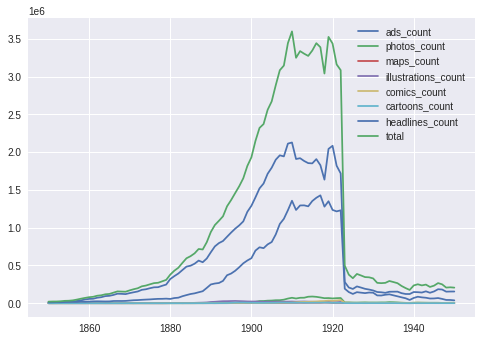

In [13]:
df.plot()

### Ads as a portion of the total

We can already see that ads make up a large proportion of the total data. Looking at ads and total only gives us a better sense of how these two relate:

<AxesSubplot:>

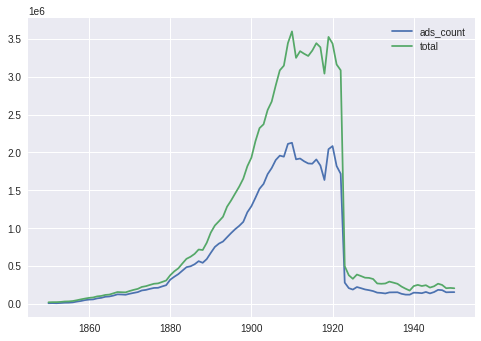

In [14]:
df[['ads_count','total']].plot()

### Stopping at 1920
We can see a steep decline of all types of image in the 1920s.

<AxesSubplot:>

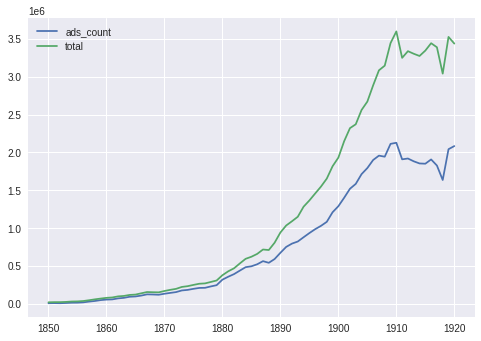

In [15]:
df[['ads_count','total']][df.index<=1920].plot()

## What does this tell us? 

This chart shows us a few different things 
- the number of images predicted as adverts (and the total of all images) predicted by the Newspaper Navigator 

There are also quite a few things which this doesn't show
- the number of adverts grew over time, up until the 1920s. This growth may be explained by more newspapers being published over time, better classifications of adverts by the newspaper navigator algorithm in later years,or a larger body of digitsed material overall in the LOC collection. 

### Why the drop?
The drop in numbers is mostly explained by the copyright status of newspapers published after this period but could also be explained by the Newspaper Navigator classifier performing worse in later years, particularly since the original training data for Newspaper Navigator was trained on WWI data. 

# Creating a sample

### Sampling

We can use ```sample``` to create samples in a few different ways. Since we're concerned with preparing a sample for annotation we want to limit how much we need to annotate. Based on the visulisations of the growth in the dataset between 1880 and 1900 we want to sample this period. 

We can use the ```create_sample``` method to create a sample between 1880 and 1900 taking a sample every 5 years. Since our aim is to limit the number of annotation instead of specifcying how much we want to sample from each year we use ```year_sample=False``` to instead for a total sample size ~500. This number isn't precise because the sample size per year is rounded up. 

This method will return a Pandas Dataframe. 

In [16]:
sampler = sample.nnSampler()

In [18]:
df = sampler.create_sample(sample_size=500, kind='ads', start_year=1860, end_year=1900, step=5, year_sample=False)

In [20]:
df.head(10)

,filepath,pub_date,page_seq_num,edition_seq_num,batch,lccn,box,score,ocr,place_of_publication,geographic_coverage,name,publisher,url,page_url
0,iahi_gastly_ver01/data/sn82015737/00279529091/...,1860-03-09,447,1,iahi_gastly_ver01,sn82015737,"[0.30762831315880534, 0.049735121606933906, 0....",0.950152,"[JTO, TMCE, An, t%E, 3eott, County, Pair, is, ...","Davenport, Iowa",[Iowa--Scott--Davenport],Daily Democrat and news. [volume],"Maguire, Richardson & Co.",https://news-navigator.labs.loc.gov/data/iahi_...,https://chroniclingamerica.loc.gov/data/batche...
1,ohi_cobweb_ver04/data/sn85026050/00280775848/1...,1860-08-17,359,1,ohi_cobweb_ver04,sn85026050,"[0.5799164973813336, 0.7307444280707744, 0.700...",0.985859,"[9, BI., I, .QJtf, A, never, falllu, Antidote,...","Fremont, Sandusky County [Ohio]",[Ohio--Sandusky--Fremont],Fremont journal. [volume],I.W. Booth,https://news-navigator.labs.loc.gov/data/ohi_c...,https://chroniclingamerica.loc.gov/data/batche...
2,curiv_jojoba_ver01/data/sn84038814/00279557207...,1860-11-22,498,1,curiv_jojoba_ver01,sn84038814,"[0.5793982023445715, 0.43399254432091344, 0.70...",0.986739,[],"Marysville, Calif.",[California--Yuba--Marysville],Daily national Democrat. [volume],A.S. Randall & Co.,https://news-navigator.labs.loc.gov/data/curiv...,https://chroniclingamerica.loc.gov/data/batche...
3,hihouml_lilac_ver02/data/sn82015408/0021247138...,1860-03-17,833,1,hihouml_lilac_ver02,sn82015408,"[0.5183942753296475, 0.5235361735026042, 0.674...",0.905783,"[C., H., L.EWEUS., NOTICE., Competition, the, ...","Honolulu [Oahu], Hawaii",[Hawaii--Honolulu--Honolulu],Polynesian. [volume],[publisher not identified],https://news-navigator.labs.loc.gov/data/hihou...,https://chroniclingamerica.loc.gov/data/batche...
4,curiv_jojoba_ver01/data/sn84038814/00279557190...,1860-02-21,816,1,curiv_jojoba_ver01,sn84038814,"[0.598211174337273, 0.0393043301089006, 0.7273...",0.918803,[],"Marysville, Calif.",[California--Yuba--Marysville],Daily national Democrat. [volume],A.S. Randall & Co.,https://news-navigator.labs.loc.gov/data/curiv...,https://chroniclingamerica.loc.gov/data/batche...
5,wvu_austria_ver01/data/sn84026845/00202190650/...,1860-03-22,277,1,wvu_austria_ver01,sn84026845,"[0.2810836642761977, 0.021020836717500463, 0.5...",0.960305,"[B., A., Fahnestock, &, Co's., PURE, WHITE, LE...","Wheeling, Va. [W. Va.]",[West Virginia--Ohio--Wheeling],Daily intelligencer. [volume],Campbell & M'Dermot,https://news-navigator.labs.loc.gov/data/wvu_a...,https://chroniclingamerica.loc.gov/data/batche...
6,tu_furry_ver01/data/sn83045628/00200293587/186...,1860-04-21,69,1,tu_furry_ver01,sn83045628,"[0.2715182629933798, 0.5381755536703364, 0.388...",0.943606,"[IL'J'S, ami, (, 'ATS,, BONNETS, till, OOODS,,...","Knoxville, Tenn.",[Tennessee--Knox--Knoxville],Brownlow's Knoxville Whig. [volume],E.B.P. Kinsloe,https://news-navigator.labs.loc.gov/data/tu_fu...,https://chroniclingamerica.loc.gov/data/batche...
7,iahi_bellsprout_ver01/data/sn84027352/00279528...,1860-02-02,444,1,iahi_bellsprout_ver01,sn84027352,"[0.5682708976804748, 0.5028207913385059, 0.703...",0.938462,"['Vimilli, 1, i, (FALL, &, WINTER, Mammoth, Cl...","Ottumwa, Iowa",[Iowa--Wapello--Ottumwa],The weekly Ottumwa courier. [volume],J.W. & G.P. Norris,https://news-navigator.labs.loc.gov/data/iahi_...,https://chroniclingamerica.loc.gov/data/batche...
8,curiv_jojoba_ver01/data/sn84038814/00279557207...,1860-07-26,87,1,curiv_jojoba_ver01,sn84038814,"[0.6939450665470904, 0.29700505687745826, 0.81...",0.959135,[],"Marysville, Calif.",[California--Yuba--Marysville],Daily national Democrat. [volume],A.S. Randall & Co.,https://news-navigator.labs.loc.gov/data/curiv...,https://chroniclingamerica.loc.gov/data/batche...
9,ohi_arnarson_ver01/data/sn83035173/00296027297...,1860-12-12,412,1,ohi_arnarson_ver01,sn83035173,"[0.053070784451668726, 0.656615614353266, 0.19...",0.946558,"[JVC, nil, whrm, if, mjiv, V.cwxoptw, !, m, JL...","Ashland, Ashland County, Ohio",[Ohio--Ashland--Ashland],The Ashland

## Save the output.

Let's make a directory to save all of the outsputs of this dataset. 

In [22]:
Path('ph/ads').mkdir(parents=True)

In [23]:
sampler.sample.to_csv('ph/ads/sample.csv')

Let's check the number per year:

In [24]:
df['pub_date'].map(lambda x: x.split('-')[0]).value_counts()

1885    61
1880    61
1870    61
1890    61
1895    61
1860    61
1875    61
1900    61
1865    61
Name: pub_date, dtype: int64

You can see that the function used to create a sample created even samples for each year. The intution here is that since we want a classifier that performs equally well on each year we want to make sure that the data is the same for each year. This could be the wrong approach, it might be better to recreate a dataset which is proprtionally sampled for each year. 

### Other info in the dataset
Let's take a look at a few other bits of the data 

In [25]:
df['publisher'].value_counts().head(15)

[publisher not identified]     17
Bingham & Doughty               9
Douglass & Conner               8
N.A. Foster & Co.               8
New York Tribune                8
S.T. Seawell & W.N. Stanton     7
J.B. Howell                     7
Maguire, Richardson & Co.       7
Post-Intelligencer Pub. Co.     6
Edward Rosewater                6
John H. Oberly & Co.            6
Edgar Snowden                   6
S. Medary                       6
Smith, Camp & Co.               5
W. & G. Dunbar, Jr.             5
Name: publisher, dtype: int64

<AxesSubplot:title={'center':'Average number of photos per month'}>

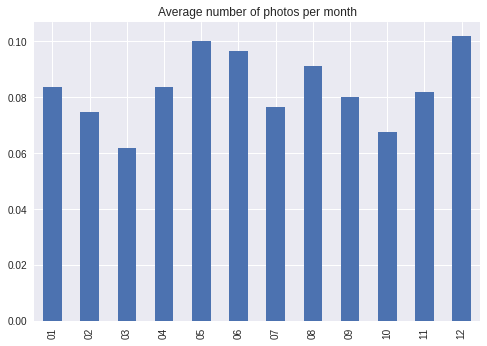

In [26]:
df['pub_date'].map(lambda x: x.split('-')[1]).value_counts(normalize=True).sort_index().plot(kind='bar', title='Average number of photos per month')

In [27]:
df['month'] = df['pub_date'].map(lambda x: x.split('-')[1])

In [28]:
df['year'] = df['pub_date'].map(lambda x:x.split('-')[0])

In [29]:
grouped = df.groupby(['year'])['month'].value_counts(normalize=True)

In [30]:
grouped

year  month
1860  05       0.163934
      04       0.131148
      07       0.114754
      02       0.098361
      08       0.098361
                 ...   
1900  10       0.081967
      01       0.065574
      04       0.049180
      07       0.049180
      03       0.032787
Name: month, Length: 107, dtype: float64

# Download sample 

To download the actual images we use `download_sample`, passing in a folder to save the output images. In this case since we already have a sample dataframe this is passed in.

In [32]:
sampler.download_sample('ph/ads/images',pct=80)

# Setup Label Studio

Label studio can be used to create annotation tasks in a few different ways. In this case it is done via the CLI. We can navigate to the images folder and run `label-studio` init to setup the annotation task. The other flags are hopefully fairly clear. 

In [10]:
import pandas as pd
df = pd.read_csv('ph/ads/images/2020_08_10_19_31_549_sample.csv',index_col=0)
df['iiif_url']

0      https://chroniclingamerica.loc.gov/iiif/2/iahi...
1      https://chroniclingamerica.loc.gov/iiif/2/ohi_...
2      https://chroniclingamerica.loc.gov/iiif/2/curi...
3      https://chroniclingamerica.loc.gov/iiif/2/hiho...
4      https://chroniclingamerica.loc.gov/iiif/2/curi...
                             ...                        
544    https://chroniclingamerica.loc.gov/iiif/2/wa_i...
545    https://chroniclingamerica.loc.gov/iiif/2/nbu_...
546    https://chroniclingamerica.loc.gov/iiif/2/kyu_...
547    https://chroniclingamerica.loc.gov/iiif/2/ct_h...
548    https://chroniclingamerica.loc.gov/iiif/2/nbu_...
Name: iiif_url, Length: 549, dtype: object

```bash
cd /ph/ads/
```

```bash
label-studio init ad_annotations --template=image_classification
```

```bash
label-studio start ./ad_annotations
```

# Define the config for the annotation task

Once you are in the label studio interface you will be prompted to define an annotation task, this can be done using an XML like template. For this task the following was used. 

```html
<View>
  <Image name="image" value="$image"></Image>
  <Choices name="choice" toName="image" showInLine="true">
    <Choice value="text-only" background="blue"></Choice>
    <Choice value="illustrations" background="green"></Choice>
  </Choices>
</View>
```

# Import images

## Annotate
Once you have loaded your images and defined the labels you can start annotating. 

# Process annotations
Once you have finished annotating, or are too bored to carry on you can use functionality from `annotate` to help process the annotations

In [4]:
from nnAnnotator import annotate

We can check what kind of information is stored with our annotations. These consist of various configuration files, and the 'completions' which are single json files which store completed annotations

In [3]:
!ls ph/ads/ad_annotations

completions config.json config.xml  tasks.json


In [4]:
!ls ph/ads/ad_annotations | head -n 5

completions
config.json
config.xml
tasks.json


In [5]:
annotations = annotate.nnAnnotations.from_completions('ph/ads/ad_annotations', 'classification')

`process_completions` can be used to put these completed annotations into a dataframe. 

In [21]:
annotations.annotation_df

,created_at,id,lead_time,result,data
0,1602236711,379001,1.248,text-only,pst_fenske_ver02_data_sn84026497_00280776129_1...
1,1602237071,396001,0.870,text-only,scu_carlacox_ver01_data_sn84026965_00294551268...
2,1602237268,115001,1.949,text-only,in_england_ver02_data_sn82015464_00202191435_1...
3,1602236719,545001,0.932,text-only,wvu_isner_ver01_data_sn86092518_0041418683A_18...
4,1602237545,400001,0.775,text-only,scu_drinksmall_ver01_data_sn93067705_002372884...
...,...,...,...,...,...
547,1602237030,244001,1.069,illustrations,mnhi_edina_ver01_data_sn90059522_0017503349A_1...
548,1602237445,497001,0.785,text-only,vtu_burlington_ver01_data_sn86072143_002807770...
549,1602236821,35001,0.780,text-only,deu_arden_ver01_data_sn85042354_00383343367_18...
550,1602237006,182001,1.161,illustrations,kyu_dracula_ver01_data_sn85052141_0020653364A_...


Next we can export these annotations to a csv file. 

In [22]:
annotations.export_annotations('ph/ads/ads.csv')

Now we have a stripped down version of the dataframe which just contains the file and the labels. 

In [26]:
df = pd.read_csv('ph/ads/ads.csv')
df.head(4)

,file,label
0,pst_fenske_ver02_data_sn84026497_00280776129_1...,text-only
1,scu_carlacox_ver01_data_sn84026965_00294551268...,text-only
2,in_england_ver02_data_sn82015464_00202191435_1...,text-only
3,wvu_isner_ver01_data_sn86092518_0041418683A_18...,text-only


### Upsample minority classes

We can see how our labels are distributed using the pandas `value_counts` method. 

In [33]:
df['label'].value_counts(normalize=True)

text-only        0.684882
illustrations    0.315118
Name: label, dtype: float64

We can see our classes are imbalanced here. Normally, it would be better to maintain the same balance of lablels. Because this dataset will be used for a tutorial I also creat a balanced version of the dataset by upsampling the data. 

In [42]:
df_majority = df[df.label=='text-only']
df_minority = df[df.label=='illustrations']

In [43]:
len(df_majority), len(df_minority)

(376, 173)

In [44]:
from sklearn.utils import resample
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),  # to match majority class
                                 random_state=42) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [45]:
df_upsampled['label'].value_counts()

text-only        376
illustrations    376
Name: label, dtype: int64

In [46]:
df_upsampled.to_csv('ph/ads/ads_upsampled.csv')

In [11]:
sample_df = pd.read_csv('ph/ads/images/2020_08_10_19_31_549_sample.csv', index_col=0)

In [12]:
annotations.merge_sample(sample_df)

In [14]:
annotations.merged_df.to_csv('ph/ads/annotated_sample.csv')

# Uploading to Zenodo 
Now we have processed the annotations we will upload them to Zenodo. We can do this using the zenodo api. To use this API you will need to create an access token. You can find documentation for the API on the [developer section](https://developers.zenodo.org/) of the Zenodo website. 

dotenv is used to load the access token from an `.env` file

In [15]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [16]:
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")

We'll use requests to upload the data, and tqdm to get a progress bar for later. 

In [17]:
import requests 
from tqdm.notebook import tqdm

The next steps are \ # TODO finalize outline 

In [18]:
r = requests.get('https://zenodo.org/api/deposit/depositions',params={'access_token': ACCESS_TOKEN})

In [19]:
r.status_code

200

In [20]:
headers = {"Content-Type": "application/json"}
params={'access_token': ACCESS_TOKEN}
r = requests.post('https://zenodo.org/api/deposit/depositions',
                   params=params,
                   json={},
                   headers=headers)
r.status_code

201

In [21]:
r.json()

{'conceptrecid': '4075210',
 'created': '2020-10-09T13:38:48.393742+00:00',
 'files': [],
 'id': 4075211,
 'links': {'bucket': 'https://zenodo.org/api/files/d379d9e9-9e7c-4d9b-8cb0-365677c567ed',
  'discard': 'https://zenodo.org/api/deposit/depositions/4075211/actions/discard',
  'edit': 'https://zenodo.org/api/deposit/depositions/4075211/actions/edit',
  'files': 'https://zenodo.org/api/deposit/depositions/4075211/files',
  'html': 'https://zenodo.org/deposit/4075211',
  'latest_draft': 'https://zenodo.org/api/deposit/depositions/4075211',
  'latest_draft_html': 'https://zenodo.org/deposit/4075211',
  'publish': 'https://zenodo.org/api/deposit/depositions/4075211/actions/publish',
  'self': 'https://zenodo.org/api/deposit/depositions/4075211'},
 'metadata': {'prereserve_doi': {'doi': '10.5281/zenodo.4075211',
   'recid': 4075211}},
 'modified': '2020-10-09T13:38:48.393755+00:00',
 'owner': 32477,
 'record_id': 4075211,
 'state': 'unsubmitted',
 'submitted': False,
 'title': ''}

In [22]:
bucket_url = r.json()["links"]["bucket"]

Once we have a bucket url we are ready to upload our files, in this case we filter out `DS_Store` and upload everything else. 

In [23]:
import os

In [24]:
dirs = [x for x in Path('ph/ads').iterdir() if x.is_dir() and not x.name.startswith('.')]
dirs

[PosixPath('ph/ads/ad_annotations'), PosixPath('ph/ads/images')]

In [25]:
!zip -j -r -q ph/ads/images.zip ph/ads/images

In [26]:
files = [f for f in Path('ph/ads').iterdir() if f.is_file() and not f.name.startswith('.')]
files

[PosixPath('ph/ads/images.zip'),
 PosixPath('ph/ads/annotated_sample.csv'),
 PosixPath('ph/ads/sample.csv'),
 PosixPath('ph/ads/ads.csv'),
 PosixPath('ph/ads/ads_upsampled.csv')]

In [27]:
for file in tqdm(files):
    with open(file,"rb") as fp:
        r = requests.put(
            "%s/%s" % (bucket_url, file),
            data=fp,
            params=params)
r.json()

{'mimetype': 'text/csv',
 'updated': '2020-10-09T13:40:29.224322+00:00',
 'links': {'self': 'https://zenodo.org/api/files/d379d9e9-9e7c-4d9b-8cb0-365677c567ed/ph/ads/ads_upsampled.csv',
  'version': 'https://zenodo.org/api/files/d379d9e9-9e7c-4d9b-8cb0-365677c567ed/ph/ads/ads_upsampled.csv?versionId=e7313ede-d5ac-4678-86f7-151ecc715073',
  'uploads': 'https://zenodo.org/api/files/d379d9e9-9e7c-4d9b-8cb0-365677c567ed/ph/ads/ads_upsampled.csv?uploads'},
 'is_head': True,
 'created': '2020-10-09T13:40:29.218245+00:00',
 'checksum': 'md5:547c8245118bc61f30d318bb9ec9d19d',
 'version_id': 'e7313ede-d5ac-4678-86f7-151ecc715073',
 'delete_marker': False,
 'key': 'ph/ads/ads_upsampled.csv',
 'size': 68332}

Once this has been done we should make sure we create an additional metadata related to the upload within Zenodo. 